### Word2vec vs BERT: Understanding the Differences

Based on the article by Ankiit on Medium.

This notebook explores the differences between Word2vec (static embeddings) and BERT (context-sensitive embeddings) using a toy corpus.

#### 1. The Major Difference: Static vs Context Sensitive

- **Word2Vec**: Generates a single, static vector for each word regardless of context. For example, the word "bank" has the same vector in "river bank" and "bank deposit".
- **BERT**: Generates dynamic vectors based on the surrounding words. The representation of "bank" changes depending on the sentence context.

#### 2. Creating a Toy Corpus
We will use a small corpus where the word "ball" appears in three different contexts: Sports, Dance, and Physics.

In [1]:
corpus = [
    'A tennis ball is green in color', 
    'A game of Cricket uses bat and ball',
    'Julie never missed a ball dance, a promenade, or a play',
    'ball dance is more traditional than a line dance',
    'ball bearings as used in mechanics',
    'Automotive ball bearings have high precision'
]

#### 3. Word2vec Training
We will train a Word2vec model using the Skip-gram architecture with a context window of 3.

In [10]:
from gensim.models import Word2Vec

# Tokenize corpus
tokenized_corpus = [i.split() for i in corpus]

# Train model
# Note: 'size' is renamed to 'vector_size' and 'iter' to 'epochs' in newer Gensim versions
w2v_model = Word2Vec(tokenized_corpus, vector_size=50,min_count=1, window=3, sg=1, epochs=5)

#### 4. Inspecting Word Vectors
Word2vec saves a lookup of words and their respective vectors. We can query the static embedding for 'ball'.

In [11]:
# See the word vector for 'ball'
print(w2v_model.wv['ball'])

[-1.10893627e-03  4.97879402e-04  1.02115851e-02  1.79747287e-02
 -1.86191145e-02 -1.42570939e-02  1.29154585e-02  1.79405883e-02
 -1.00585474e-02 -7.53118657e-03  1.47656361e-02 -3.06705129e-03
 -9.08808596e-03  1.30933216e-02 -9.71368793e-03 -3.62406415e-03
  5.75997401e-03  2.00706092e-03 -1.65737122e-02 -1.89101100e-02
  1.46207735e-02  1.01410560e-02  1.35721788e-02  1.54791423e-03
  1.26845809e-02 -6.80413516e-03 -1.86330895e-03  1.15204593e-02
 -1.50274746e-02 -7.87901692e-03 -1.50206722e-02 -1.87168235e-03
  1.90819800e-02 -1.46627696e-02 -4.65855701e-03 -3.86404130e-03
  1.61792450e-02 -1.18546085e-02  6.26363180e-05 -9.51519143e-03
 -1.91692039e-02  9.99308843e-03 -1.75147168e-02 -8.75890255e-03
 -5.21863658e-05 -6.13568060e-04 -1.53393215e-02  1.92301217e-02
  9.95441154e-03  1.84724256e-02]


#### 5. Visualization with t-SNE
We can plot the word vectors in 2D space to visualize their relationships.

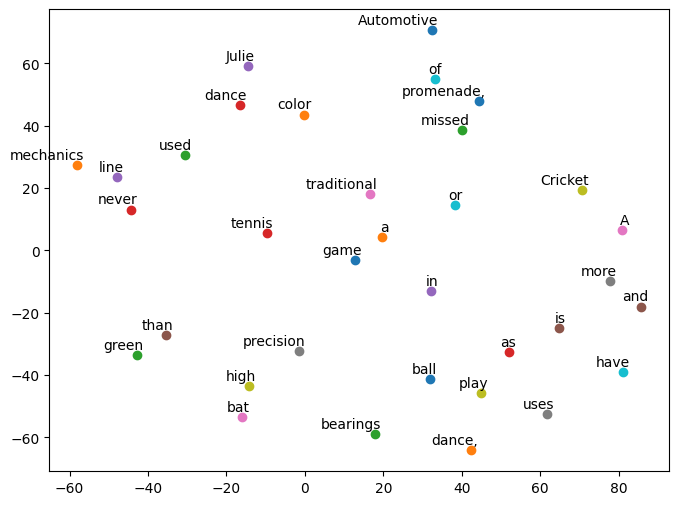

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    # FIX: Iterate over 'index_to_key' instead of 'vocab'
    for word in model.wv.index_to_key:
        tokens.append(model.wv[word]) # FIX: Access vectors via model.wv[word]
        labels.append(word)
    
    # Convert tokens to a numpy array (often safer for sklearn)
    tokens = np.array(tokens)

    tsne_model = TSNE(perplexity=5, n_components=2, init='pca', max_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(8, 6)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

# Call the function
tsne_plot(w2v_model)

#### 6. Saving and Loading the Model
The model can be saved and reloaded for downstream tasks.

In [15]:
# Save model
w2v_model.save("word2vec.model")

# Load model
loaded_model = Word2Vec.load("word2vec.model")

# Usage examples
# Add .wv before .most_similar
print("Most similar to 'ball':", loaded_model.wv.most_similar('ball'))

Most similar to 'ball': [('play', 0.2701249420642853), ('green', 0.24096034467220306), ('line', 0.21081078052520752), ('never', 0.18632163107395172), ('mechanics', 0.1671648919582367), ('missed', 0.1618003100156784), ('as', 0.15022145211696625), ('of', 0.1456301510334015), ('precision', 0.1320522427558899), ('bearings', 0.12695440649986267)]


#### 7. BERT: The Contextual Alternative

Unlike the static lookups in Word2vec, BERT models (based on Transformers) are trained as language representation models.

**Key Differences Summary:**

| Feature | Word2Vec | BERT |
|---------|----------|------|
| **Training** | Simple single-layered NN trained on n-grams. | 12-layer deep transformer trained on Masked LM and Next Sentence Prediction. |
| **Vectors** | Saves one vector per word (Static). | Generates vectors based on context (Dynamic). |
| **Application** | Used as a lookup matrix. | Used as an input head to other classifiers or fine-tuned directly. |

BERT requires pre-training (often computationally expensive) or using pre-trained weights (e.g., via Hugging Face) and then fine-tuning for specific tasks.

In [16]:
!pip install transformers torch

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\laragon\bin\python\python-3.13\python.exe -m pip install --upgrade pip


In [17]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 1. Load pre-trained BERT model and tokenizer
# 'bert-base-uncased' is a standard, efficient version of BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(sentence, target_word):
    """
    Extracts the BERT embedding for a specific word in a sentence.
    """
    # Tokenize the sentence and convert to tensor format
    inputs = tokenizer(sentence, return_tensors="pt")
    
    # Find the index of the target word in the tokens
    # Note: BERT adds [CLS] at start and [SEP] at end
    input_ids = inputs['input_ids'][0]
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    try:
        word_idx = tokens.index(target_word)
    except ValueError:
        print(f"Word '{target_word}' not found in sentence: {sentence}")
        return None

    # Pass inputs through the model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # The 'last_hidden_state' has shape (batch_size, seq_len, hidden_dim)
    # We grab the vector for our target word index
    embedding = outputs.last_hidden_state[0][word_idx].numpy()
    return embedding

# 2. Select sentences with different contexts
sentences = [
    'A tennis ball is green in color',       # Sports context
    'Julie never missed a ball dance',       # Social/Dance context
    'ball bearings as used in mechanics'     # Mechanical context
]

# 3. Extract embeddings for 'ball' from each sentence
ball_vectors = []
print("Extracting BERT vectors for 'ball'...")
for sent in sentences:
    vec = get_bert_embedding(sent, 'ball')
    ball_vectors.append(vec)

# 4. Compare the vectors using Cosine Similarity
# If these were Word2Vec, the similarity would be 1.0 (identical).
# With BERT, we expect them to be different (< 1.0).
sim_1_2 = cosine_similarity([ball_vectors[0]], [ball_vectors[1]])[0][0]
sim_1_3 = cosine_similarity([ball_vectors[0]], [ball_vectors[2]])[0][0]

print(f"\nContext 1: '{sentences[0]}'")
print(f"Context 2: '{sentences[1]}'")
print(f"Context 3: '{sentences[2]}'")
print("-" * 50)
print(f"Similarity (Sports vs Dance):     {sim_1_2:.4f}")
print(f"Similarity (Sports vs Mechanics): {sim_1_3:.4f}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\boume\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\boume\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Extracting BERT vectors for 'ball'...

Context 1: 'A tennis ball is green in color'
Context 2: 'Julie never missed a ball dance'
Context 3: 'ball bearings as used in mechanics'
--------------------------------------------------
Similarity (Sports vs Dance):     0.6198
Similarity (Sports vs Mechanics): 0.2173


In [21]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch

# ==========================================
# 1. DEFINE SEARCH FUNCTIONS
# ==========================================

def get_w2v_sentence_vector(sentence, model):
    """Calculates sentence vector by averaging word vectors (Bag of Words approach)"""
    words = sentence.split()
    # Only keep words that exist in our toy W2V model
    valid_words = [word for word in words if word in model.wv.index_to_key]
    
    if not valid_words:
        return np.zeros(model.vector_size)
    
    # Average the vectors
    return np.mean([model.wv[word] for word in valid_words], axis=0)

def search_w2v(query, corpus, model):
    query_vec = get_w2v_sentence_vector(query, model)
    
    # Calculate similarity with every sentence in corpus
    scores = []
    for sent in corpus:
        sent_vec = get_w2v_sentence_vector(sent, model)
        # Reshape for sklearn cosine_similarity (1, -1)
        sim = cosine_similarity([query_vec], [sent_vec])[0][0]
        scores.append((sent, sim))
    
    # Sort by score descending
    return sorted(scores, key=lambda x: x[1], reverse=True)

def search_bert(query, corpus):
    """Encodes query and corpus using BERT and compares them"""
    # 1. Encode Query
    inputs = tokenizer(query, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        query_emb = model(**inputs).last_hidden_state.mean(dim=1).numpy()
    
    scores = []
    for sent in corpus:
        # 2. Encode Candidate Sentence
        inputs = tokenizer(sent, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            sent_emb = model(**inputs).last_hidden_state.mean(dim=1).numpy()
        
        sim = cosine_similarity(query_emb, sent_emb)[0][0]
        scores.append((sent, sim))
        
    return sorted(scores, key=lambda x: x[1], reverse=True)

# ==========================================
# 2. RUN COMPARISON
# ==========================================

# Define a query that is NOT in the training data, but semantically related
query = "red"

print(f"Query: '{query}'\n")

print("--- Word2Vec Search Results (Trained on toy corpus) ---")
# This will likely fail or be poor because 'sport' and 'equipment' 
# might not be in the tiny training vocabulary.
results_w2v = search_w2v(query, corpus, w2v_model)
for sent, score in results_w2v[:2]:
    print(f"[{score:.4f}] {sent}")

print("\n--- BERT Search Results (Pre-trained) ---")
# BERT knows what 'sport' is from its massive pre-training.
results_bert = search_bert(query, corpus)
for sent, score in results_bert[:2]:
    print(f"[{score:.4f}] {sent}")

Query: 'red'

--- Word2Vec Search Results (Trained on toy corpus) ---
[0.0000] A tennis ball is green in color
[0.0000] A game of Cricket uses bat and ball

--- BERT Search Results (Pre-trained) ---
[0.5073] A tennis ball is green in color
[0.4284] Automotive ball bearings have high precision
